In [1]:
options(warn=-1)
options(readr.num_columns = 0)

library(tidyverse)
library(kableExtra)
library(ggplot2)
library(caret)
library(class)

churn <- read_csv("../_build/data/churn_train.csv")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



Attaching package: 'kableExtra'



The following object is masked from 'package:dplyr':

    group_rows



Loading required package: lattice



Attaching package: 'caret'



The following object is masked from 'package:purrr':

    lift



# The Bias-Variance Tradeoff

An open question from the previous section is how to choose the value of the hyperparameter $k$. To explore this, let's return to the simplified `churn` data set, which only has 100 observations and two independent features (`total_intl_charge` and `account_length`). 

To visualize the kNN model when $k$ equals five, we can plot the **decision boundary** of our model on this data, or the line that partitions the feature space into two classes. In the plot below, the area shaded in red represents points where a majority of the five nearest neighbors churned. Similarly, the area shaded in blue represents points where a majority of the five nearest neighbors did *not* churn. Therefore, this plot shows how our kNN model separates the data into two classes.

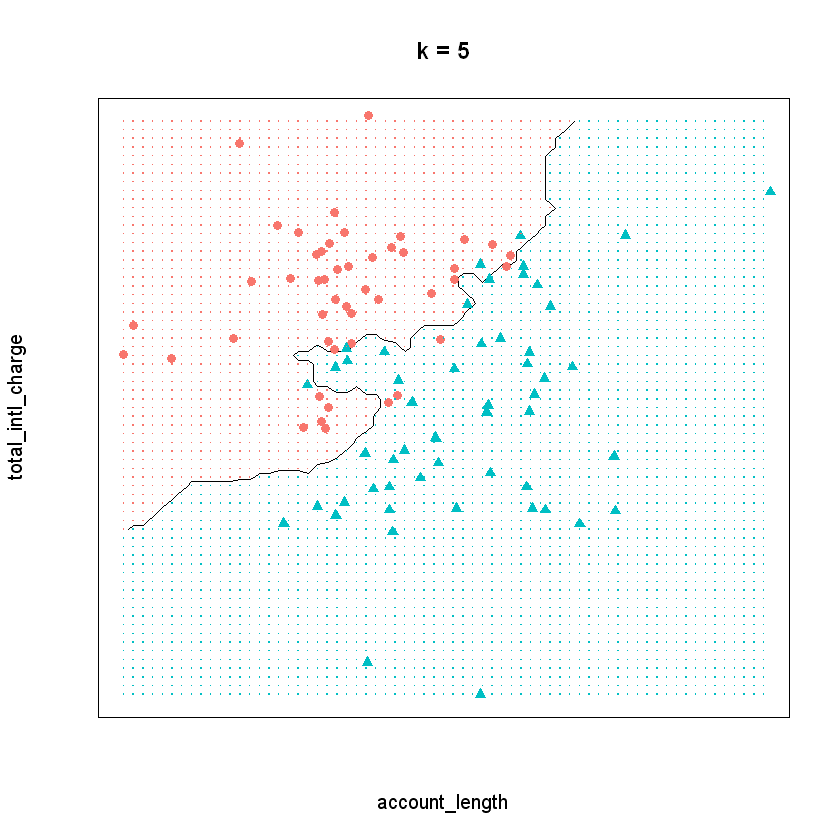

In [2]:
churnSample <- read_csv("../_build/data/churn_sample.csv")
churnSample$account_length <- (churnSample$account_length - min(churnSample$account_length)) / (max(churnSample$account_length) - min(churnSample$account_length))
churnSample$total_intl_charge <- (churnSample$total_intl_charge - min(churnSample$total_intl_charge)) / (max(churnSample$total_intl_charge) - min(churnSample$total_intl_charge))
# get the range of x1 and x2
rx1 <- range(churnSample$account_length)
rx2 <- range(churnSample$total_intl_charge)
# get lattice points in predictor space
px1 <- seq(from = rx1[1], to = rx1[2], by = 0.015 )
px2 <- seq(from = rx2[1], to = rx2[2], by = 0.015 )
xnew <- expand.grid(x1 = px1, x2 = px2)

# get the contour map
k=5
knnK <- knn(train = churnSample[,1:2], test = xnew, cl = churnSample$churn, k = k, prob = TRUE)
prob <- attr(knnK, "prob")
prob <- ifelse(knnK=="1", prob, 1-prob)
probK <- matrix(prob, nrow = length(px1), ncol = length(px2))

# Figure 2.2
#par(mar = rep(2,4))
contour(px1, px2, probK, levels=0.5, labels="", xlab="account_length", ylab="total_intl_charge", axes=FALSE)
points(churnSample[,1:2], col=ifelse(churnSample[,3]==1, "#F8766D", "#00BFC4"),
       pch=ifelse(churnSample[,3]==1, 19, 17))
points(xnew, pch=".", cex=1.2, col=ifelse(probK>0.5, "#F8766D", "#00BFC4"),
       shape=ifelse(churnSample[,3]==1, "a", "b"))
title(xlab="account_length", ylab="total_intl_charge", main=paste0("k = ", k))
box()

Now observe what happens if we run the model with a $k$ of one instead. By decreasing the value of $k$, we have increased the "sensitivity" of the model. In other words, the decision boundary now contorts itself so that every single point in the data set lies in the correct region; there is not a single misclassified observation. Compare that to the model when $k$ equals five, where the decision boundary is less flexible and there are some observations in the wrong region.

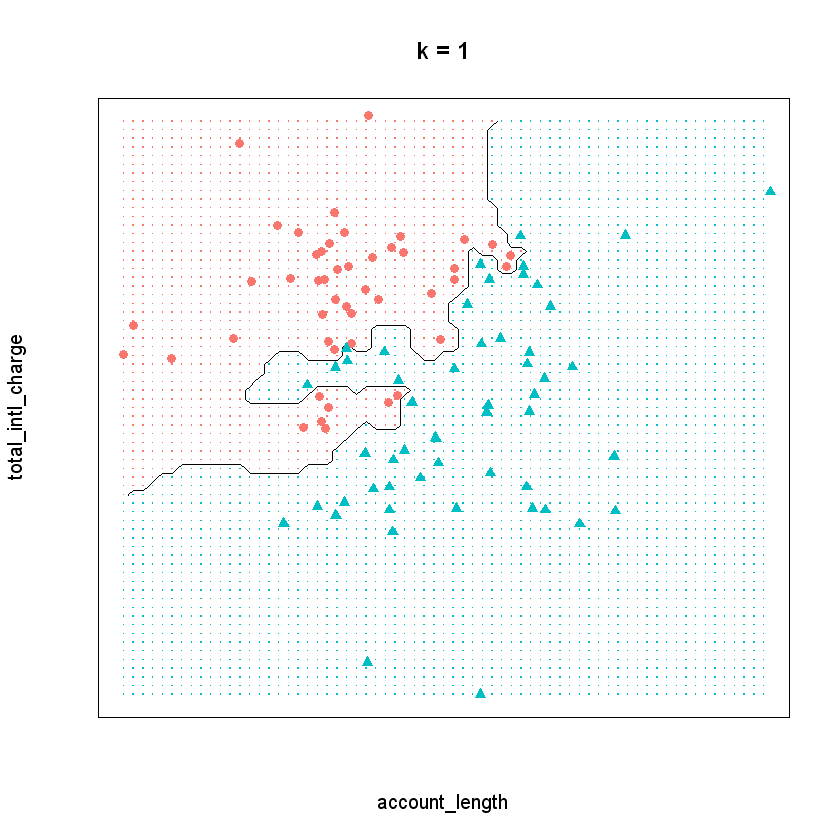

In [3]:
k=1
knnK <- knn(train = churnSample[,1:2], test = xnew, cl = churnSample$churn, k = k, prob = TRUE)
prob <- attr(knnK, "prob")
prob <- ifelse(knnK=="1", prob, 1-prob)
probK <- matrix(prob, nrow = length(px1), ncol = length(px2))

# Figure 2.2
#par(mar = rep(2,4))
contour(px1, px2, probK, levels=0.5, labels="", xlab="account_length", ylab="total_intl_charge", axes=FALSE)
points(churnSample[,1:2], col=ifelse(churnSample[,3]==1, "#F8766D", "#00BFC4"),
       pch=ifelse(churnSample[,3]==1, 19, 17))
points(xnew, pch=".", cex=1.2, col=ifelse(probK>0.5, "#F8766D", "#00BFC4"),
       shape=ifelse(churnSample[,3]==1, "a", "b"))
title(xlab="account_length", ylab="total_intl_charge", main=paste0("k = ", k))
box()

Finally, let's see the decision boundary when we set $k$ to twenty. Now the model seems much more inflexible - the boundary is almost a straight line and does not closely adhere to any individual point.

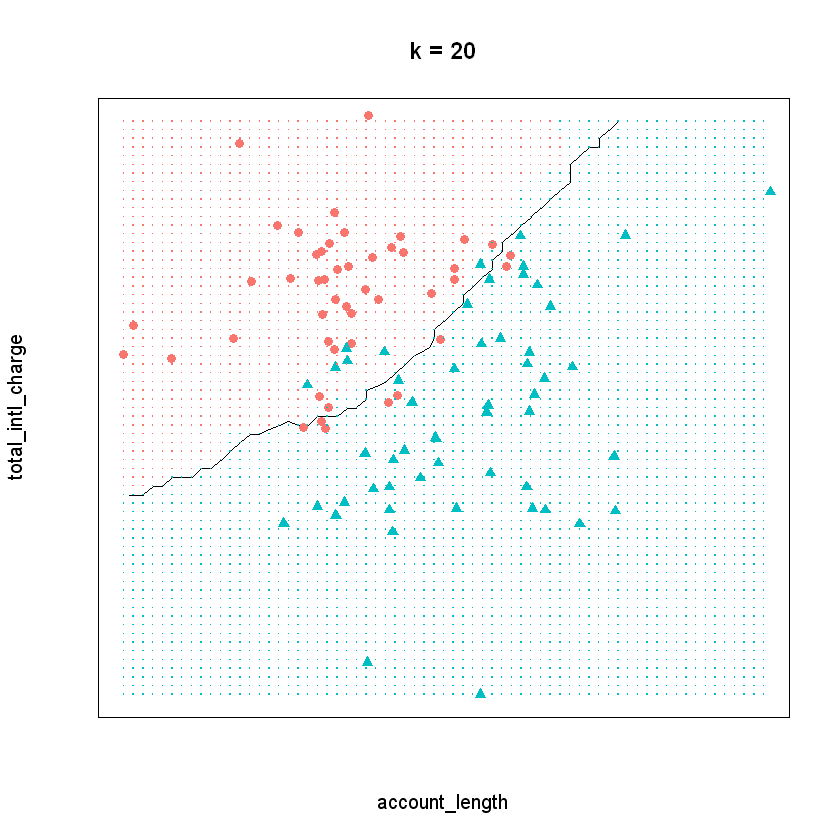

In [4]:
k=20
knnK <- knn(train = churnSample[,1:2], test = xnew, cl = churnSample$churn, k = k, prob = TRUE)
prob <- attr(knnK, "prob")
prob <- ifelse(knnK=="1", prob, 1-prob)
probK <- matrix(prob, nrow = length(px1), ncol = length(px2))

# Figure 2.2
#par(mar = rep(2,4))
contour(px1, px2, probK, levels=0.5, labels="", xlab="account_length", ylab="total_intl_charge", axes=FALSE)
points(churnSample[,1:2], col=ifelse(churnSample[,3]==1, "#F8766D", "#00BFC4"),
       pch=ifelse(churnSample[,3]==1, 19, 17))
points(xnew, pch=".", cex=1.2, col=ifelse(probK>0.5, "#F8766D", "#00BFC4"),
       shape=ifelse(churnSample[,3]==1, "a", "b"))
title(xlab="account_length", ylab="total_intl_charge", main=paste0("k = ", k))
box()

Which one of these scenarios is best? It may be tempting to assume that the best model is the one where $k$ equals one. After all, this model provides the closest fit to the data. However, this is often not the case due to a principle known as the bias-variance tradeoff. The **bias-variance tradeoff** refers to the tension between how closely a model fits its training data, versus how well it generalizes to unseen data. 

For the kNN algorithm, the closest fit is achieved when $k$ equals one. The primary issue is that this fit is likely *too* close. When $k$ is very low, the model may be so flexible that it starts to pick up on the random idiosyncrasies of the training data. Remember that we are building our model on a sample of data, and the information that sample provides is a combination of **signal** and **noise**. The signal of the sample reflects the true, underlying relationships between the variables of interest. This information is generalizable to other observations not in our sample, and is therefore useful for building our predictive model. The noise of the sample refers to the random variation that is unique to the particular observations in the training data. When a model starts to fit the noise of a sample, we say that it is **overfitting** the data. 

Access the web application below to further explore the overfitting and the bias-variance tradeoff.

<a href="https://hbs-data-science.shinyapps.io/overfitting/" class="btn btn-primary" style="color:white;" target="_blank">Launch Application!</a>

Ultimately we want our model to be flexible enough that it can pick up the signal in the sample, but not so flexible that it starts to pick up on the noise. This is the essence of the bias-variance tradeoff. What, then, is the value of $k$ that correctly balances this tradeoff? Unfortunately, there is no single correct answer. The right value for $k$ depends on the properties of the data set one is working with. Therefore, data scientists typically divide their data up into train and validation sets to test different values of $k$, according to a variety of performance metrics. This process is described in the next chapter.